# TelecomX - Pt.2 📊
## Predição de Evasão de Clientes (Churn Prediction)
---

In [25]:
# imports de bibliotecas e dos dados tratados da pt1

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE

# Carregar dataset do GitHub (raw)
url = "https://raw.githubusercontent.com/Bainazz/TelecomX--Pt.2/main/dados_tratados.csv"
df = pd.read_csv(url)

df.head()

,customerID,Churn,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges_Monthly,Charges_Total,Charges_Daily
0,0002-ORFBO,No,Female,No,Yes,Yes,9,Yes,No,DSL,...,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30,2.20
1,0003-MKNFE,No,Male,No,No,No,9,Yes,Yes,DSL,...,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40,2.01
2,0004-TLHLJ,Yes,Male,No,No,No,4,Yes,No,Fiber optic,...,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85,2.34
3,0011-IGKFF,Yes,Male,Yes,Yes,No,13,Yes,No,Fiber optic,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85,3.17
4,0013-EXCHZ,Yes,Female,Yes,Yes,No,3,Yes,No,Fiber optic,...,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40,2.97


## 2. Preparação dos Dados

In [26]:
# remoção de colunas irrelevantes
if "customerID" in df.columns:
    df.drop("customerID", axis=1, inplace=True)

# encoding (One-hot)
df_encoded = pd.get_dummies(df, drop_first=True)
df_encoded.head()

,Tenure,Charges_Monthly,Charges_Total,Charges_Daily,Churn_Yes,Gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,9,65.6,593.30,2.20,False,False,False,True,True,True,...,False,True,False,False,True,False,True,False,False,True
1,9,59.9,542.40,2.01,False,True,False,False,False,True,...,False,False,False,True,False,False,False,False,False,True
2,4,73.9,280.85,2.34,True,True,False,False,False,True,...,False,False,False,False,False,False,True,False,True,False
3,13,98.0,1237.85,3.17,True,True,True,True,False,True,...,False,True,False,True,False,False,True,False,True,False
4,3,83.9,267.40,2.97,True,False,True,True,False,True,...,False,True,False,False,False,False,True,False,False,True


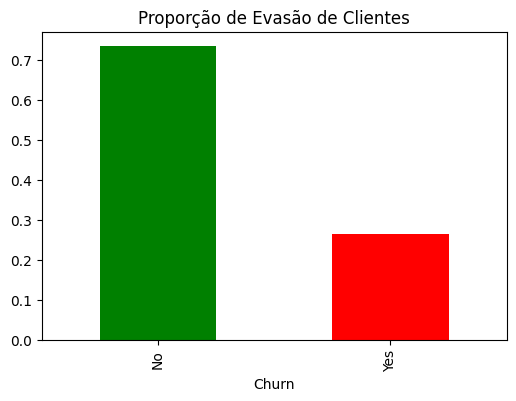

Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64


In [27]:
# proporção de evasão
plt.figure(figsize=(6,4))
df["Churn"].value_counts(normalize=True).plot(kind="bar", color=["green","red"])
plt.title("Proporção de Evasão de Clientes")
plt.show()

print(df["Churn"].value_counts(normalize=True))

In [28]:
# tratamento de valores ausentes
print("Valores nulos antes do tratamento:\n", df_encoded.isnull().sum())

# preenche valores numéricos faltantes com a média
for col in df_encoded.select_dtypes(include=[np.number]).columns:
    df_encoded[col].fillna(df_encoded[col].mean(), inplace=True)

# preenche variáveis categóricas (se tiver) com o valor mais frequente
for col in df_encoded.select_dtypes(include=['object']).columns:
    df_encoded[col].fillna(df_encoded[col].mode()[0], inplace=True)

print("Valores nulos depois do tratamento:\n", df_encoded.isnull().sum())

Valores nulos antes do tratamento:
 Tenure                                    0
Charges_Monthly                           0
Charges_Total                            11
Charges_Daily                            11
Churn_Yes                                 0
Gender_Male                               0
SeniorCitizen_Yes                         0
Partner_Yes                               0
Dependents_Yes                            0
PhoneService_Yes                          0
MultipleLines_No phone service            0
MultipleLines_Yes                         0
InternetService_Fiber optic               0
InternetService_No                        0
OnlineSecurity_No internet service        0
OnlineSecurity_Yes                        0
OnlineBackup_No internet service          0
OnlineBackup_Yes                          0
DeviceProtection_No internet service      0
DeviceProtection_Yes                      0
TechSupport_No internet service           0
TechSupport_Yes                         

/tmp/ipython-input-1310493279.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[col].fillna(df_encoded[col].mean(), inplace=True)


In [29]:
# balanceamento com SMOTE
X = df_encoded.drop("Churn_Yes", axis=1)
y = df_encoded["Churn_Yes"]

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

print("Antes do SMOTE:", y.value_counts())
print("Depois do SMOTE:", y_res.value_counts())

Antes do SMOTE: Churn_Yes
False    5174
True     1869
Name: count, dtype: int64
Depois do SMOTE: Churn_Yes
False    5174
True     5174
Name: count, dtype: int64


## 3. Correlação e Seleção de Variáveis

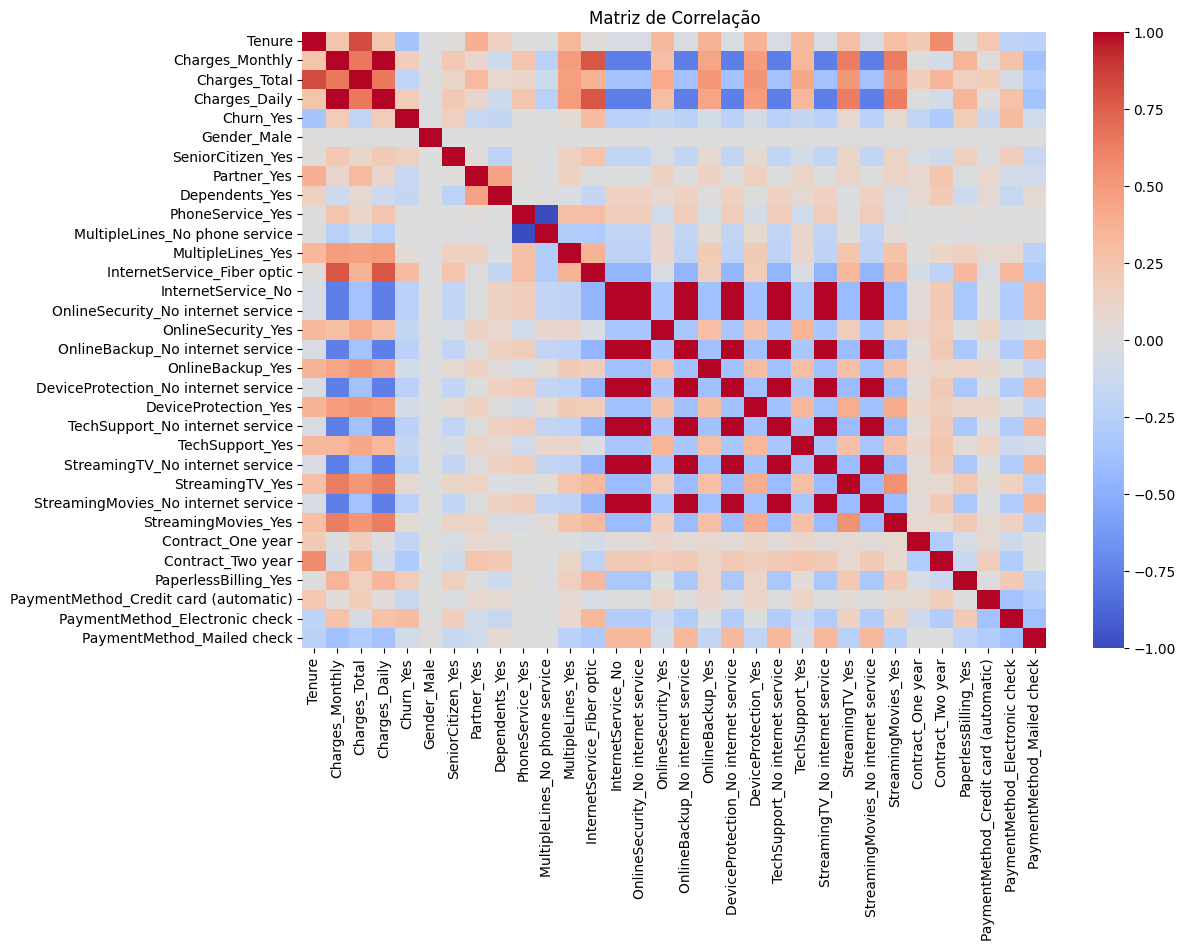

In [30]:
plt.figure(figsize=(12,8))
sns.heatmap(df_encoded.corr(), cmap="coolwarm", center=0)
plt.title("Matriz de Correlação")
plt.show()

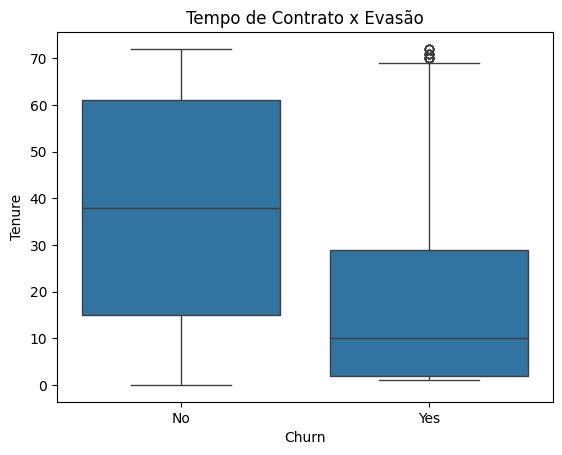

In [31]:
# tempo de contrato x evasão
sns.boxplot(x="Churn", y="Tenure", data=df)
plt.title("Tempo de Contrato x Evasão")
plt.show()

# total gasto x evasão
if "TotalCharges" in df.columns:
    sns.boxplot(x="Churn", y="TotalCharges", data=df)
    plt.title("Total Gasto x Evasão")
    plt.show()

## 4. Modelagem Preditiva

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42, stratify=y_res)

In [33]:
# regressão Logística com normalização
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_scaled, y_train)
y_pred_log = logreg.predict(X_test_scaled)

In [34]:
# random Forest sem normalização
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

## 5. Avaliação dos Modelos

In [35]:
def avaliar_modelo(y_true, y_pred, nome_modelo):
    print(f"--- {nome_modelo} ---")
    print("Acurácia:", accuracy_score(y_true, y_pred))
    print("Precisão:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1-score:", f1_score(y_true, y_pred))
    print("\nMatriz de Confusão:\n", confusion_matrix(y_true, y_pred))
    print("\nRelatório de Classificação:\n", classification_report(y_true, y_pred))

avaliar_modelo(y_test, y_pred_log, "Regressão Logística")
avaliar_modelo(y_test, y_pred_rf, "Random Forest")

--- Regressão Logística ---
Acurácia: 0.8293075684380032
Precisão: 0.8246505717916137
Recall: 0.836340206185567
F1-score: 0.8304542546385156

Matriz de Confusão:
 [[1277  276]
 [ 254 1298]]

Relatório de Classificação:
               precision    recall  f1-score   support

       False       0.83      0.82      0.83      1553
        True       0.82      0.84      0.83      1552

    accuracy                           0.83      3105
   macro avg       0.83      0.83      0.83      3105
weighted avg       0.83      0.83      0.83      3105

--- Random Forest ---
Acurácia: 0.8473429951690822
Precisão: 0.8402777777777778
Recall: 0.8576030927835051
F1-score: 0.8488520408163265

Matriz de Confusão:
 [[1300  253]
 [ 221 1331]]

Relatório de Classificação:
               precision    recall  f1-score   support

       False       0.85      0.84      0.85      1553
        True       0.84      0.86      0.85      1552

    accuracy                           0.85      3105
   macro avg       0

## 6. Interpretação e Conclusões

/tmp/ipython-input-3748017163.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices][:10], y=X.columns[indices][:10], palette="viridis")


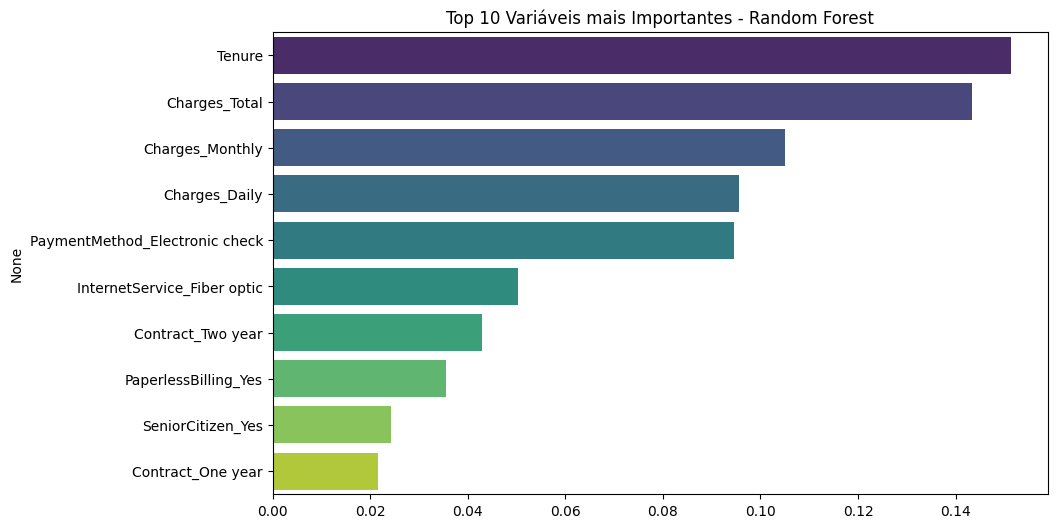

In [36]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
sns.barplot(x=importances[indices][:10], y=X.columns[indices][:10], palette="viridis")
plt.title("Top 10 Variáveis mais Importantes - Random Forest")
plt.show()